In [21]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

water_data=pd.read_csv('chennai_reservoir_levels.csv')
rain_data=pd.read_csv('chennai_reservoir_rainfall.csv')

In [22]:
water_data.describe()

,POONDI,CHOLAVARAM,REDHILLS,CHEMBARAMBAKKAM
count,6182.000000,6182.000000,6182.000000,6182.000000
mean,1106.739588,226.404589,1592.321652,1321.460555
std,1004.555050,266.886855,915.243744,951.791133
min,0.900000,0.000000,0.000000,0.000000
25%,202.000000,26.000000,847.250000,459.250000
50%,783.150000,89.000000,1685.000000,1264.000000
75%,1918.000000,411.000000,2320.000000,2046.750000
max,3231.000000,896.000000,3300.000000,3396.000000


In [59]:
water_data

,Date,POONDI,CHOLAVARAM,REDHILLS,CHEMBARAMBAKKAM
0,2004-01-01,3.9,0.0,268.0,0.0
1,2004-01-02,3.9,0.0,268.0,0.0
2,2004-01-03,3.9,0.0,267.0,0.0
3,2004-01-04,3.9,0.0,267.0,0.0
4,2004-01-05,3.8,0.0,267.0,0.0
...,...,...,...,...,...
6177,2020-11-29,2814.0,403.0,2819.0,3120.0
6178,2020-11-30,2848.0,465.0,2833.0,3120.0
6179,2020-12-01,2902.0,504.0,2841.0,3123.0
6180,2020-12-02,2873.0,547.0,2847.0,3125.0


In [23]:
import datetime
year=[i+2004 for i in range(17)]
input_data=[]
label=[]

water_data.iloc[:,0]=pd.to_datetime(water_data.iloc[:,0],format="%d-%m-%Y")
###  data (日期 前年水庫水位 前年降雨量 (label)當年水庫水位)
data=water_data.iloc[:,[0,1]]
y=[data.iloc[i,0].year for i in range(len(data))]
data=pd.concat([pd.DataFrame({'year':y}),data,rain_data['POONDI']],axis=1)
data.columns=['year','Date','POONDI','POONDI_rain']
group=data.groupby('year')

for i in range(len(year)-1):
    if i %2 ==0:
        input_data.append(group.get_group(year[i]).drop(['year'],axis=1))
    else:
        label.append(group.get_group(year[i])['POONDI'])

In [102]:
input_data[1]

,Date,POONDI,POONDI_rain
731,2006-01-01,3231.0,0.0
732,2006-01-02,3231.0,0.0
733,2006-01-03,3231.0,0.0
734,2006-01-04,3231.0,0.0
735,2006-01-05,3231.0,0.0
...,...,...,...
1091,2006-12-27,2867.0,0.0
1092,2006-12-28,2883.0,0.0
1093,2006-12-29,2896.0,0.0
1094,2006-12-30,2905.0,0.0


In [24]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler=MinMaxScaler()
scaler.fit(data.iloc[:,2:])

scaler_l=MinMaxScaler()
scaler_l.fit(np.array(data.iloc[:,2]).reshape( (-1,1) ) )

class dataset(Dataset):
    def __init__(self,data,label) -> None:
        super().__init__()
        for i in range(len(data)):
            
            for j in range(len(data[i])):
                data[i].iloc[j,0]=( (j+1)/365 )
            data[i].iloc[:,1:]=scaler.transform(data[i].iloc[:,1:])

            data[i]=np.array(data[i]).astype(np.float64)
            if len(data[i])!=366:
                data[i]=np.vstack((data[i],np.array([-1,-1,-1])))

                
            
            label[i]=np.array(label[i]).astype(np.float64)
            label[i]=scaler_l.transform(label[i].reshape((-1,1)))
            if len(label[i]!=366):
                label[i]=np.concatenate( (label[i],np.array( [[-1]] ) ) )
        self.data=torch.Tensor(np.array(data))
        self.data=torch.squeeze(self.data)
        self.label =torch.Tensor( np.array(label) )
        self.label=torch.squeeze(self.label)
    def __getitem__(self,index):
        return self.data[index],self.label[index]
    def __len__(self):
        return len(self.data)

In [25]:
traindataset=dataset(input_data[:6].copy(),label[:6].copy())
testdataset=dataset(input_data[6:].copy(),label[6:].copy())

traindataload=DataLoader(dataset=traindataset,batch_size=1,shuffle=False)
testdataload=DataLoader(dataset=testdataset,batch_size=1,shuffle=False)

Transformer

In [26]:
emb_count=0
for i in range(len(data.columns)):
    emb_count+=len(data.groupby(data.columns[i]).size())

In [27]:
##建立模型
from torch.nn import Transformer



class transfomer(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.emb=nn.Embedding(emb_count,8,max_norm=5,padding_idx=-1)
        ##
        self.act=nn.ReLU(inplace=False)
        self.soft=nn.Softmax(dim=366)
        ## encoder
        self.att1=nn.MultiheadAttention(embed_dim=12,num_heads=4,dropout=0,batch_first=True)
        self.Wo1=nn.Linear( 366*12 , 366*3 ,bias=False)
        self.ln1=nn.LayerNorm(366*3)
        self.FF1=nn.Linear(366*3,366*3)

        self.D1=nn.Dropout(0.3)

        ## decoder
        self.maskatt=nn.MultiheadAttention(embed_dim=12,num_heads=4,batch_first=True,bias=False)
        self.Wo2=nn.Linear(366*12 , 366*3 , bias=False)
        self.mask=Transformer.generate_square_subsequent_mask(366)
        self.ln2=nn.LayerNorm(366*3)
        self.att2=nn.MultiheadAttention(embed_dim=12,num_heads=4,batch_first=True)
        self.Wo3=nn.Linear(366*12 , 366*3 , bias=False)
        self.FF2=nn.Linear(366*3,366*3)

        self.D2=nn.Dropout(0.3)

        ## out layer
        self.out=nn.Linear(366*3,3)
        self.wl=nn.Linear(366*3,366)

    def forward(self,src,tgt):

        ##embedding
        #src=self.emb(src)
        #tgt=self.emb(tgt)
        ##encoder
        self.encoder_layer=2
        for i in range(self.encoder_layer):
            temp=src
            for j in range(3):#HEAD
                temp=torch.cat( (src,temp),2 )
            e_x,e_xw=self.att1(query=temp,key=temp,value=temp,need_weights=True)#
            e_x=self.D1(e_x)
            e_x=torch.flatten(e_x,start_dim=1,end_dim=-1)
            
            e_x=self.Wo1(e_x) ####轉換所有HEAD結果
           
            temp=self.act(e_x) ###ReLU過濾不必要資料

            temp=torch.reshape(temp,(-1,366,3) )
            
            e_x=src+temp
            e_x=torch.flatten(e_x,start_dim=1,end_dim=-1)
            temp=self.ln1(e_x) ## Norm
            temp=self.D1(temp)

            e_x=self.FF1(temp)
            e_x=self.D1(e_x)

            e_x+=temp##ADD
            e_x=self.ln1(e_x)
            src=torch.reshape(e_x,(-1,366,3) )
   
        ##decoder
        self.decoder_layer=1
        for k in range(366):#input_lenth/ouput_lenth
            for i in range(self.decoder_layer):
                if k!=0:
                    for j in range(len(tgt)):######################
                        out=out.reshape((-1,1,3))
                        for t in range(1):
                            tgt[j][((k-1)*1)+t]=out[j][t]
                    temp=tgt
                    for j in range(3):
                        temp=torch.cat( (tgt,temp), 2 )

                    d_x,d_xw=self.maskatt(query=temp,key=temp,value=temp,need_weights=True,attn_mask=self.mask)
                    d_x=self.D2(d_x)
                    d_x=torch.flatten(d_x,start_dim=1,end_dim=-1)
                    
                    d_x=self.Wo2(d_x)
                   
                    temp=self.act(d_x)

                    temp=torch.reshape(temp,(-1,366,3))

                    d_x=tgt+temp
                    d_x=torch.flatten(d_x,start_dim=1,end_dim=-1)
                    d_x=self.ln2(d_x)
                else:
                    d_x=torch.zeros(e_x.shape)
                e_x=torch.reshape(e_x,(-1,366,3) )

                temp=e_x
                for j in range(3):
                    temp=torch.cat( (e_x,temp), 2 )

                temp,w=self.att2(query=temp,key=temp,value=temp,need_weights=True)
                temp=self.D2(temp)

                temp=torch.flatten(temp,start_dim=1,end_dim=-1)
                
                temp=self.Wo3(temp)
                temp=self.act(temp) ###ReLU過濾不必要資料
                
                
                d_x+=temp
                temp=self.ln2(d_x)
                temp=self.D2(temp)
                    
                d_x=self.FF2(temp)
                d_x=self.D2(d_x)
                d_x+=temp

                d_x=self.ln2(d_x)

            ##out
            out=self.out(d_x)
       
        for j in range(len(tgt)):######################
            for t in range(1):
                tgt[j][((k-1)*1)+t]=out[j][t]
        tgt=torch.flatten(tgt,start_dim=1,end_dim=-1)
        f_out=self.wl(tgt)
       # f_out=self.act(f_out)
        return f_out


            

In [28]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
###bilstm pytorch

class bilstm(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.lstm=nn.LSTM(3,3,dropout=0,num_layers=1,bidirectional=True,batch_first=True)  
        self.act=nn.ReLU(inplace=False)
        self.fc2=nn.Linear(in_features=366*3*2,out_features=366*3,bias=False) 
        self.Drop=nn.Dropout(0.3)

        self.out=nn.Linear(in_features=366*3,out_features=366,bias=False)
        

        #self.mse=nn.MSELoss()
    
    def forward(self,inputs):###前向傳遞
        out,(h_n,c_n) =self.lstm(inputs) ###out=output h_n=hidden_state c_n=cell_state

        out=torch.flatten(out,start_dim=1,end_dim=-1)
        
        out=self.fc2(out)
        out=self.Drop(out)
        out=self.act(out)
        out=self.out(out)
        
        return out
    

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import ReLU
from keras import optimizers


train=[]
train_label=[]
for idx,(data,label) in enumerate(traindataload):
    train.append(np.array(torch.squeeze(data)))
    train_label.append(np.array(torch.squeeze(label)))
    
train=np.array(train)
train_label=np.array(train_label)

##bilstm keras
opt=optimizers.Adam(learning_rate=0.0005)
bi_lstm=Sequential()


bi_lstm.add(Bidirectional(LSTM(units=3,return_sequences = True,input_shape=(366,3) ) ) )
bi_lstm.add(Flatten() )
bi_lstm.add(Dense(366*3))
bi_lstm.add(Dropout(0.3))
bi_lstm.add(ReLU())

bi_lstm.add(Dense(units=366))
bi_lstm.compile(optimizer = 'adam', loss = 'MeanSquaredError',metrics=['MAE'])

history=bi_lstm.fit(train,train_label,epochs=50,batch_size=1)


Epoch 1/50
6/6 [==============================] - 3s 40ms/step - loss: 0.2142 - MAE: 0.3550
Epoch 2/50
6/6 [==============================] - 0s 40ms/step - loss: 0.1603 - MAE: 0.3154
Epoch 3/50
6/6 [==============================] - 0s 44ms/step - loss: 0.1116 - MAE: 0.2621
Epoch 4/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0808 - MAE: 0.2271
Epoch 5/50
6/6 [==============================] - 0s 38ms/step - loss: 0.0578 - MAE: 0.1883
Epoch 6/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0521 - MAE: 0.1741
Epoch 7/50
6/6 [==============================] - 0s 38ms/step - loss: 0.0414 - MAE: 0.1533
Epoch 8/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0428 - MAE: 0.1557
Epoch 9/50
6/6 [==============================] - 0s 37ms/step - loss: 0.0378 - MAE: 0.1495
Epoch 10/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0390 - MAE: 0.1506
Epoch 11/50
6/6 [==============================] - 0s 37ms/step - loss: 0.0316 

In [29]:
##訓練

ms='b'
if ms=='t':
    tr_model=transfomer()
    opt=Adam(tr_model.parameters(), lr=0.0005)
else:
    model=bilstm()
    opt=Adam(model.parameters(), lr=0.0005)
epoch=50

loss_func=nn.MSELoss()
MAE=nn.L1Loss()

cos_func=nn.CosineSimilarity()
his_MAE=[]
his_COS=[]
his_loss=[]

cos_func=nn.CosineSimilarity()
for e in range(epoch):
    r_loss=[]

    r_MAE=[]
    
    r_COS=[]
    

    if e % 10 == 0 & e !=0:
            for p in opt.param_groups:
                p['lr']*=1
    for idx,(data,label) in enumerate(traindataload):
        #print(data)
        if ms=='t':
            result=tr_model.forward(data,data)
            opt.zero_grad()
            """
            
            
            with torch.no_grad():
                r_cos.append(np.mean(np.array(cos_func(result,label))) )
            """
            loss = loss_func( result, label )
            loss.backward()
            A=MAE(result,label)
            P=cos_func(result,label)
            r_MAE.append(A.item())
            r_COS.append(P.item())
            r_loss.append(loss.item())
            opt.step()
        elif ms=='b':
            result=model.forward(data)
            opt.zero_grad()
            loss = loss_func( result, label )
            loss.backward()
            A=MAE(result,label)
            P=cos_func(result,label)
            r_MAE.append(A.item())
            r_COS.append(P.item())
            r_loss.append(loss.item())
            opt.step()
    
    avg_MAE=np.mean(r_MAE)
    avg_COS=np.mean(r_COS)
    avg_losses= np.mean(r_loss)
    his_loss.append(avg_losses)
    his_MAE.append(avg_MAE)
    his_COS.append(avg_COS)
    print(f"epoch:{e}, loss:{avg_losses}, MAE:{avg_MAE}, COS:{avg_COS}")
    if e != 0:
        if his_loss[-1] > (his_loss[-2]+0.03):
            print('loss increase')
            break
        
if ms=='t':
    his_loss_T=his_loss
    his_MAE_T=his_MAE
    his_COS_T=his_COS  

epoch:0, loss:0.21926751857002577, MAE:0.3812550827860832, COS:0.5391984739496062
epoch:1, loss:0.12366321434577306, MAE:0.2912195300062497, COS:0.8134330709775289
epoch:2, loss:0.09109747782349586, MAE:0.24967708935340246, COS:0.8322812716166178
epoch:3, loss:0.10171202446023624, MAE:0.26727622002363205, COS:0.827906608581543
epoch:4, loss:0.08584196430941422, MAE:0.24821758518616358, COS:0.8395629823207855
epoch:5, loss:0.07356010377407074, MAE:0.22842089583476385, COS:0.8457342584927877
epoch:6, loss:0.08800719492137432, MAE:0.24523502588272095, COS:0.8558812936147054
epoch:7, loss:0.07197819588085015, MAE:0.223405788342158, COS:0.8595594267050425
epoch:8, loss:0.06829139621307452, MAE:0.21947183459997177, COS:0.8719732364018759
epoch:9, loss:0.0638595384856065, MAE:0.20619798948367438, COS:0.8879612783590952
epoch:10, loss:0.056024047546088696, MAE:0.19245857497056326, COS:0.8976945181687673
epoch:11, loss:0.047068645556767784, MAE:0.1740338678161303, COS:0.9004438022772471
epoch:1

In [71]:
torch.save(model,'transformer-CH.pt')

In [30]:
tr_model=torch.load('transformer_act-relu.pt')

Text(0, 0.5, 'MSE')

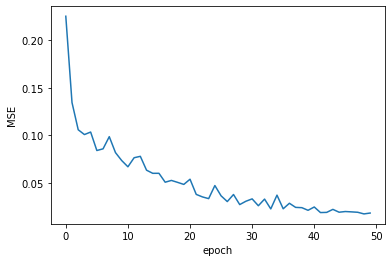

In [110]:
plt.plot(his_loss)
plt.plot(v_his_loss,color='r')
plt.xlabel('epoch')
plt.ylabel('MSE')

In [32]:
from torchmetrics import R2Score

pred=[]
lab=[]
ev=R2Score()
rel=nn.ReLU()
ms='b'
v_his_MAE=[]
v_his_COS=[]
v_his_loss=[]
with torch.no_grad(): ##不計算梯度
    for idx,(data,label) in enumerate(testdataload):
        v_COS=[]
        v_MAE=[]
        v_loss=[]
        if ms=='t':
            result=tr_model(data,data)
            #result=rel(result)
            loss = loss_func( result, label )
            A=MAE(result,label)
            P=cos_func(result,label)
            v_MAE.append(A.item())
            v_COS.append(P.item())
            v_loss.append(loss.item())
            if idx ==0:
                pre_tr=np.array(result)
                lab=np.array(label)
            else :
                pre_tr=np.vstack( ( pre_tr,np.array(result) ) )
                lab=np.vstack( ( lab,np.array(label) ) )
        elif ms =='b':
            result=model(data)
            loss = loss_func( result, label )
            A=MAE(result,label)
            P=cos_func(result,label)
            v_MAE.append(A.item())
            v_COS.append(P.item())
            v_loss.append(loss.item())
        #result=rel(result)
        #opt.zero_grad()
        #result=torch.split(result,29,dim=1)
        
        #label=torch.reshape(label,(-1,10))
        #result=torch.reshape(result,(-1,10))
            if idx ==0:
                pre_bi=np.array(result)
                lab=np.array(label)
            else :
                pre_bi=np.vstack( ( pre_bi,np.array(result) ) )
                lab=np.vstack( ( lab,np.array(label) ) )
    avg_MAE=np.mean(v_MAE)
    avg_COS=np.mean(v_COS)
    avg_losses= np.mean(v_loss)
    v_his_loss.append(avg_losses)
    v_his_MAE.append(avg_MAE)
    v_his_COS.append(avg_COS)
    print(f"loss:{avg_losses}, MAE:{avg_MAE}, COS:{avg_COS}")
#print('r2score:',r2)
if ms=='t':
    v_his_loss_T=v_his_loss
    v_his_MAE_T=v_his_MAE
    v_his_COS_T=v_his_COS  

loss:0.03497897461056709, MAE:0.13782541453838348, COS:0.73987877368927


In [159]:
print(f"loss:{v_his_loss_T[-1]}, MAE:{v_his_MAE_T[-1]}, COS:{v_his_COS[-1]}")

loss:0.05535436421632767, MAE:0.18203192949295044, COS:0.829414427280426


In [167]:
##keras

test=[]
lab=[]

for idx,(data,label) in enumerate(testdataload):
    test.append(np.array(torch.squeeze(data)))
    lab.append(np.array(torch.squeeze(label)))
test=np.array(test)
lab=np.array(lab)

pre_ker=bi_lstm.predict(test)

1/1 [==============================] - 0s 65ms/step


c:\Users\user\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimiza

'\nresiduals = pd.DataFrame(model_fit.resid)\n\nfig, ax = plt.subplots(2,1)\nresiduals.plot(title="Residuals", ax=ax[0])\nresiduals.plot(kind=\'kde\', title=\'Density\', ax=ax[1])\nplt.show()\n'

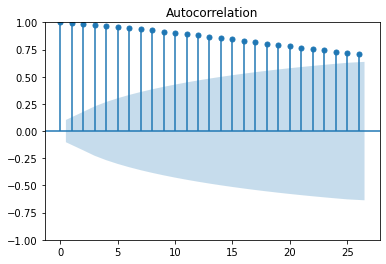

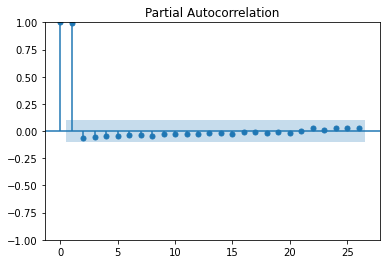

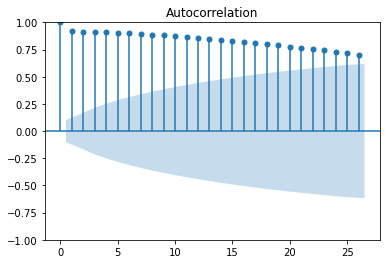

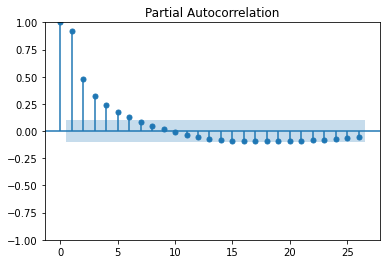

In [18]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import ndiffs
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm
test=[]
test_label=[]
for idx,(data,label) in enumerate(testdataload):
    test.append(np.array(torch.split(torch.squeeze(data),1,dim=1) [1]) )
    #test_label.append(np.array(torch.squeeze(label)))
prediction=[]


d= ndiffs(test[1], test='adf')
#print(d) # 1,2

diff=[1,2]
acf=[25,25]
pacf=[2,5]
for i in range(2):
    plot_acf(test[i])
    plot_pacf(test[i])
for i in range(len(test)):
    model = sm.tsa.arima.ARIMA(test[i],order=(acf[i],diff[i],pacf[i]))
    model_fit = model.fit()
    prediction.append( model_fit.predict(1,366,dynamic=False) )
#print(model_fit.summary())

"""
residuals = pd.DataFrame(model_fit.resid)

fig, ax = plt.subplots(2,1)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
"""




In [33]:
lab=lab.reshape((-1,366,1))
#pre_ker=pre_ker.reshape((-1,366,1))
pre_tr=pre_tr.reshape((-1,366,1))
pre_bi=pre_bi.reshape((-1,366,1))
for i in range(len(lab)):
    lab[i]=scaler_l.inverse_transform(lab[i])
    #pre_ker[i]=scaler_l.inverse_transform(pre_ker[i])
    pre_tr[i]=scaler_l.inverse_transform(pre_tr[i])
    pre_bi[i]=scaler_l.inverse_transform(pre_bi[i])
    prediction[i]=scaler_l.inverse_transform(prediction[i].reshape(-1,1))

In [ ]:
from sklearn.metrics import r2_score

for i in range(len(lab)):
    print("keras bilstm",i,r2_score(lab[i],pre_ker[i]))
    print("pytorch bilstm",i,r2_score(lab[i],pre_bi[i]))
    print("pytorch transfomer",i,r2_score(lab[i],pre_tr[i]))
  

In [34]:
from sklearn.metrics import r2_score

for i in range(len(lab)):
    #print("keras bilstm",i,r2_score(lab[i],pre_ker[i]))
    print("pytorch bilstm",i,r2_score(lab[i],pre_bi[i]))
    print("pytorch transfomer",i,r2_score(lab[i],pre_tr[i]))
    print("ARIMA",i,r2_score(lab[i],prediction[i]))

pytorch bilstm 0 0.6758268212698366
pytorch transfomer 0 0.1362499354305884
ARIMA 0 -7.299053389562392
pytorch bilstm 1 -0.143608654811338
pytorch transfomer 1 -0.6561717504999416
ARIMA 1 -1.2476674915661894


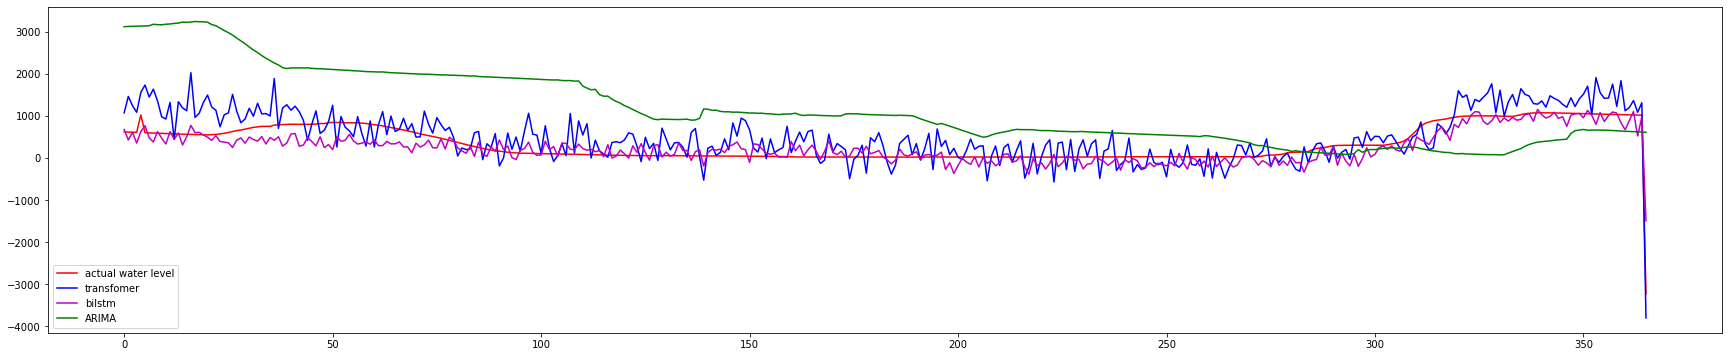

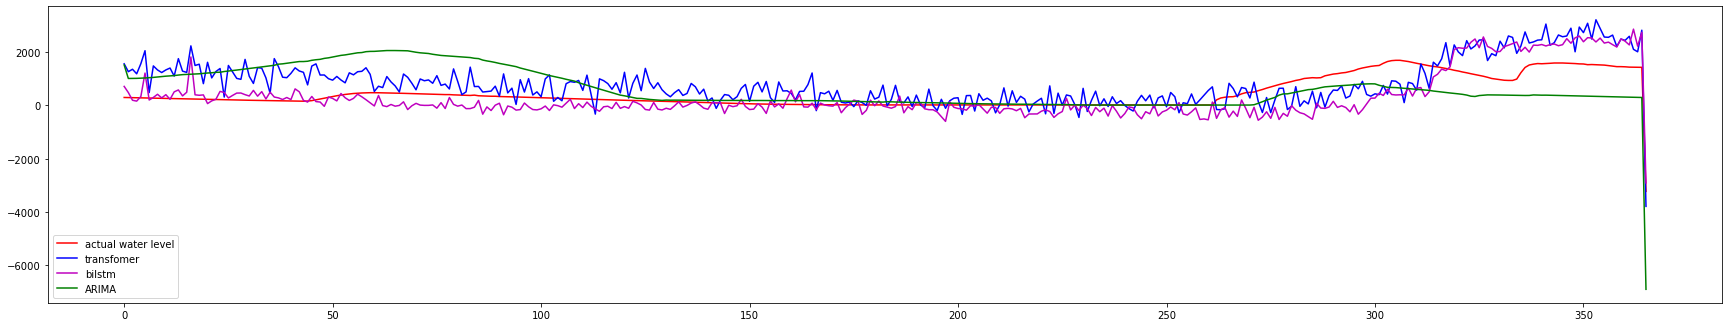

In [35]:

import matplotlib.pyplot as plt
for i in range(len(lab)):
    plt.figure(figsize=(30,(i+1)*6))
    plt.subplot(i+1,1,1)
    plt.plot(range(366),lab[i],color='r',label='actual water level')
    plt.plot(range(366),pre_tr[i],color='b',label='transfomer')
    #plt.plot(range(366),pre_ker[i],color='k',label='keras bilstm')
    plt.plot(range(366),pre_bi[i],color='m',label='bilstm')
    plt.plot(range(366),prediction[i],color='g',label='ARIMA')
    plt.legend(loc='lower left')

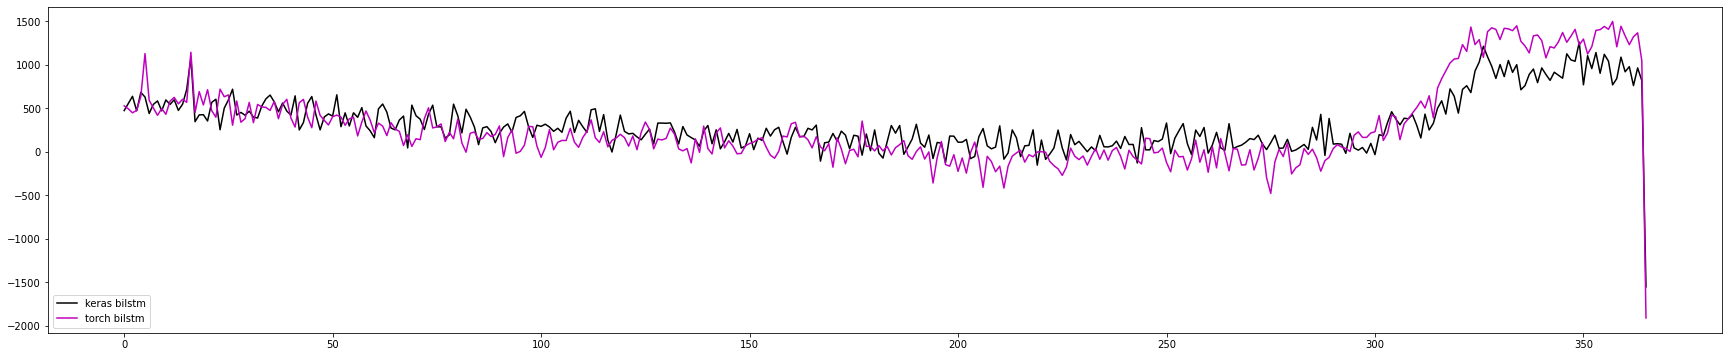

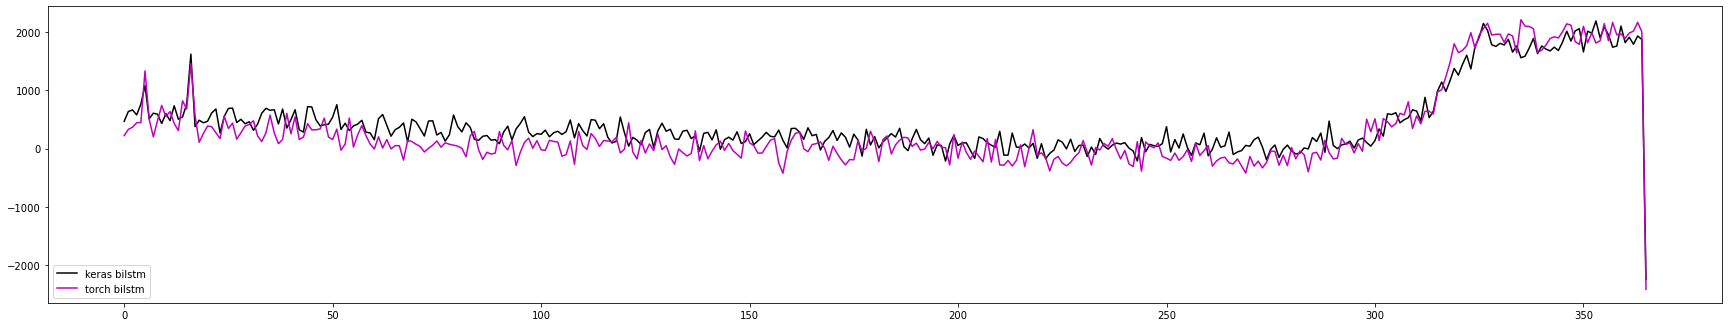

In [171]:
import matplotlib.pyplot as plt
for i in range(len(lab)):
    plt.figure(figsize=(30,(i+1)*6))
    plt.subplot(i+1,1,1)
   # plt.plot(range(366),lab[i],color='r')
    #plt.plot(range(366),pre_tr[i],color='b',label='transfomer')
    plt.plot(range(366),pre_ker[i],color='k',label='keras bilstm')
    plt.plot(range(366),pre_bi[i],color='m',label='torch bilstm')
    plt.legend(loc='lower left')

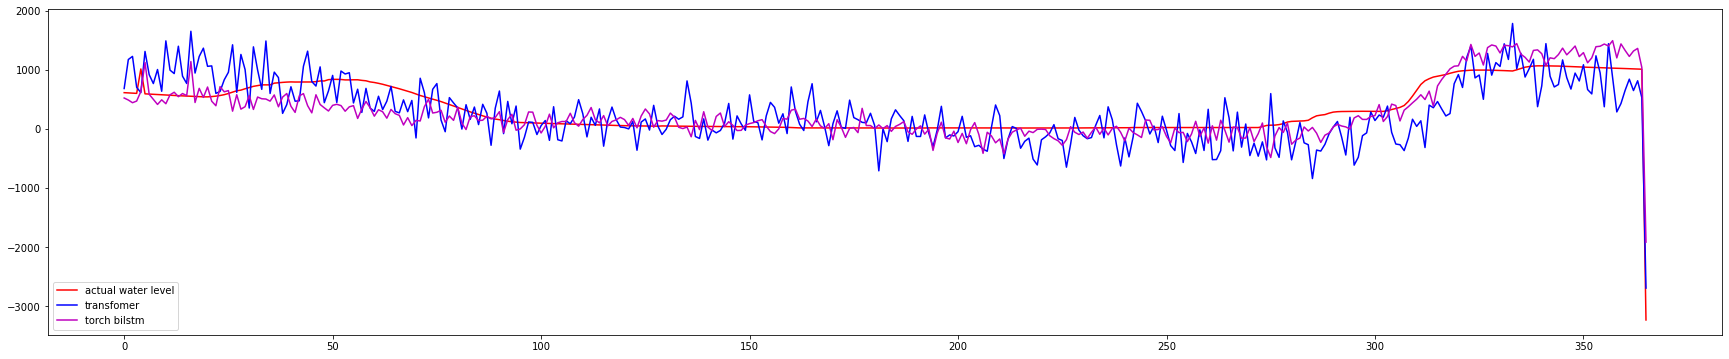

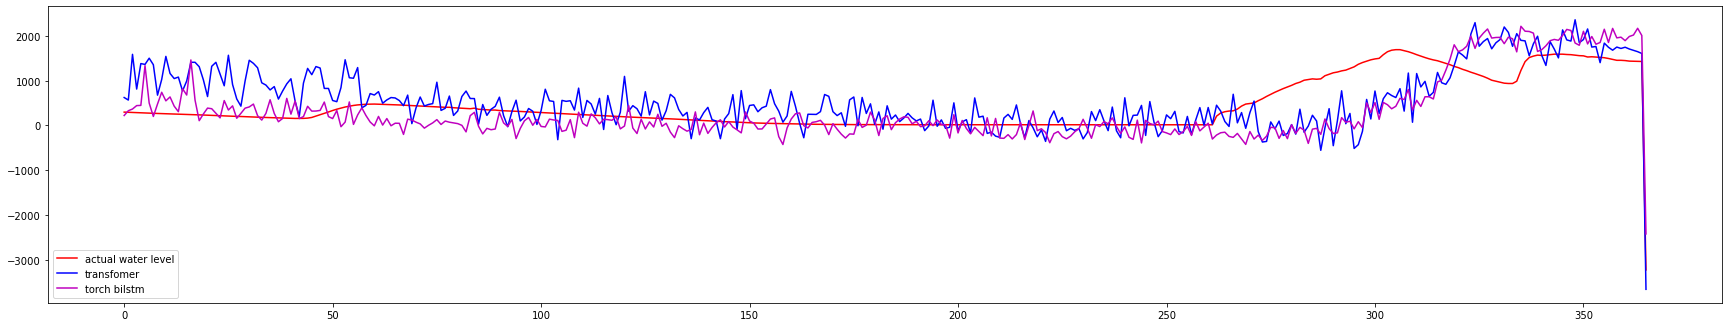

In [172]:
import matplotlib.pyplot as plt
for i in range(len(lab)):
    plt.figure(figsize=(30,(i+1)*6))
    plt.subplot(i+1,1,1)
    plt.plot(range(366),lab[i],color='r',label='actual water level')
    plt.plot(range(366),pre_tr[i],color='b',label='transfomer')
   # plt.plot(range(366),pre_ker[i],color='g',label='keras bilstm')
    plt.plot(range(366),pre_bi[i],color='m',label='torch bilstm')
    plt.legend(loc='lower left')

圖表 (數值套用先前實驗結果)

Text(0.5, 1.0, '2017')

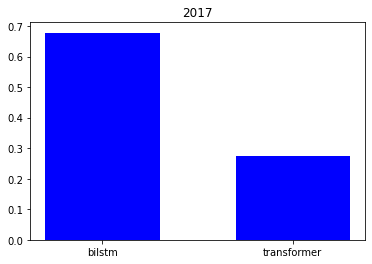

In [3]:
import matplotlib.pyplot as plt
r2_2017=[0.678,0.274] #0.274


plt.bar(['bilstm','transformer'],r2_2017,color='b',label='r2',width=0.6)
plt.title('2017')

Text(0.5, 1.0, '2019')

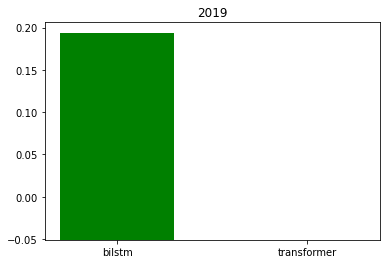

In [18]:
r2_2019=[0.194,-0.051]
r2_2019=[0.194+0.051,-0.051+0.051]
plt.bar(['bilstm','transformer'],r2_2019,color='g',label='2019',width=0.6,bottom=-0.051)
plt.title('2019')

In [124]:
print(his_loss[-1],his_MAE[-1],his_MAPE[-1])

0.01873237593099475 0.1047285832464695 0.1047285832464695


In [11]:
b= [0.02189, 0.1273,0.840 ] #,0.840
t= [0.055,0.182,0.829] #,0.829

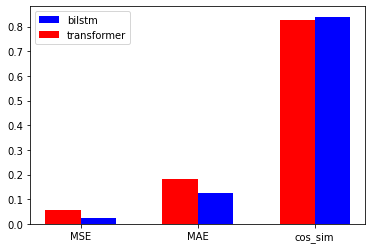

In [15]:
plt.bar(['MSE','MAE','cos_sim'],b,color='b',label='bilstm',width=0.3,align='edge')
plt.bar(['MSE','MAE','cos_sim'],t,color='r',label='transformer',width=-0.3,align='edge')
plt.legend()